## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

import sklearn as sklear

import core.dataframe_modeler as cdatmode
import core.signal_processing as csigproc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im.kibot.data.load.futures_forward_contracts as imkdlffoco
import im.kibot.data.load.kibot_s3_data_loader as imkdlksdlo
import im.kibot.metadata.load.kibot_metadata as imkmlkime

/.../amp/core/dataframe_modeler.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

# Packages
         python: 3.7.9
       gluonnlp: 0.10.0
        gluonts: 0.6.3
         joblib: 0.17.0
          mxnet: 1.7.0
          numpy: 1.19.4
         pandas: 1.1.4
        pyarrow: 2.0.0
          scipy: 1.5.3
        seaborn: 0.11.0
        sklearn: 0.23.2
    statsmodels: 0.12.1
# Last commits:
  *   d06fe90b Paul     Merge pull request #1002 from alphamatic/PTask6691_Update_master_model_analyzer (   6 hours ago) Mon Feb 1 20:34:47 2021  (HEAD -> master, origin/master, origin/HEAD)
  |\  
  | *   aaca3923 Paul     Merge branch 'master' into PTask6691_Update_master_model_analyzer (   6 hours ago) Mon Feb 1 20:33:04 2021           
  | |\  
  | |/  
  |/|   
  * |   db92f259 Paul     Merge pull request #997 from alphamatic/PTask7141_multiple_columns_in_apply_volatility_model (   6 hours ago) Mon Feb 1 20:32:01 2021           
  |\ \  


## Map contracts to start and end dates

In [3]:
lfc_hc = imkmlkime.KibotHardcodedContractLifetimeComputer(365, 7)

lfc_hc.compute_lifetime("CLJ17")

ContractLifetime(start_date=Timestamp('2016-03-22 00:00:00'), end_date=Timestamp('2017-03-15 00:00:00'))

In [4]:
lfc_ta = imkmlkime.KibotTradingActivityContractLifetimeComputer()

lfc_ta.compute_lifetime("CLJ17")

ContractLifetime(start_date=Timestamp('2011-11-18 00:00:00'), end_date=Timestamp('2017-03-21 00:00:00'))

In [5]:
symbols = ["ES", "CL", "NG"]
file = "../contracts.csv"


fcl = imkmlkime.FuturesContractLifetimes(file, lfc_hc)

In [6]:
fcl.save(["CL", "NG"])

Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
data = fcl.load(["NG"])

In [8]:
data["NG"].head()

,symbol,contract,start_date,end_date
0,NG,NGV09,2008-09-22,2009-09-15
1,NG,NGX09,2008-10-21,2009-10-14
2,NG,NGZ09,2008-11-20,2009-11-13
3,NG,NGF10,2008-12-22,2009-12-15
4,NG,NGG10,2009-01-20,2010-01-13


## Create continuous contracts

In [9]:
fcem = imkmlkime.FuturesContractExpiryMapper(data)

In [10]:
fcem.get_nth_contract("NG", "2010-01-01", 1)

'NGG10'

In [11]:
srs = fcem.get_nth_contracts("NG", "2010-01-10", "2010-01-20", freq="B", n=1)

In [12]:
srs

2010-01-11    NGG10
2010-01-12    NGG10
2010-01-13    NGG10
2010-01-14    NGH10
2010-01-15    NGH10
2010-01-18    NGH10
2010-01-19    NGH10
2010-01-20    NGH10
Freq: B, Name: NG1, dtype: object

In [13]:
kdl = imkdlksdlo.KibotS3DataLoader()

In [14]:
ffc_obj = imkdlffoco.FuturesForwardContracts(kdl)

In [15]:
ffc_obj._replace_contracts_with_data(srs)

,open,high,low,close,vol
2010-01-11,5.576,5.625,5.371,5.454,120791.0
2010-01-12,5.485,5.605,5.354,5.591,109931.0
2010-01-13,5.588,5.785,5.432,5.733,158387.0
2010-01-14,5.721,5.769,5.458,5.570,93989.0
2010-01-15,5.572,5.707,5.500,5.671,70561.0
2010-01-18,NaN,NaN,NaN,NaN,NaN
2010-01-19,5.596,5.661,5.431,5.536,86171.0
2010-01-20,5.569,5.600,5.440,5.467,40131.0


## Combine front and back contracts - price

In [16]:
contract_df = fcem.get_contracts(
    ["NG" + str(j) for j in range(1, 13)], "2010-01-01", "2015-12-31", freq="B"
)

In [17]:
contract_df.head()

,NG1,NG2,NG3,NG4,NG5,NG6,NG7,NG8,NG9,NG10,NG11,NG12
2010-01-01,NGG10,NGH10,NGJ10,NGK10,NGM10,NGN10,NGQ10,NGU10,NGV10,NGX10,NGZ10,NGF11
2010-01-04,NGG10,NGH10,NGJ10,NGK10,NGM10,NGN10,NGQ10,NGU10,NGV10,NGX10,NGZ10,NGF11
2010-01-05,NGG10,NGH10,NGJ10,NGK10,NGM10,NGN10,NGQ10,NGU10,NGV10,NGX10,NGZ10,NGF11
2010-01-06,NGG10,NGH10,NGJ10,NGK10,NGM10,NGN10,NGQ10,NGU10,NGV10,NGX10,NGZ10,NGF11
2010-01-07,NGG10,NGH10,NGJ10,NGK10,NGM10,NGN10,NGQ10,NGU10,NGV10,NGX10,NGZ10,NGF11


In [18]:
price_df = ffc_obj.replace_contracts_with_data(contract_df, "close")

<AxesSubplot:>

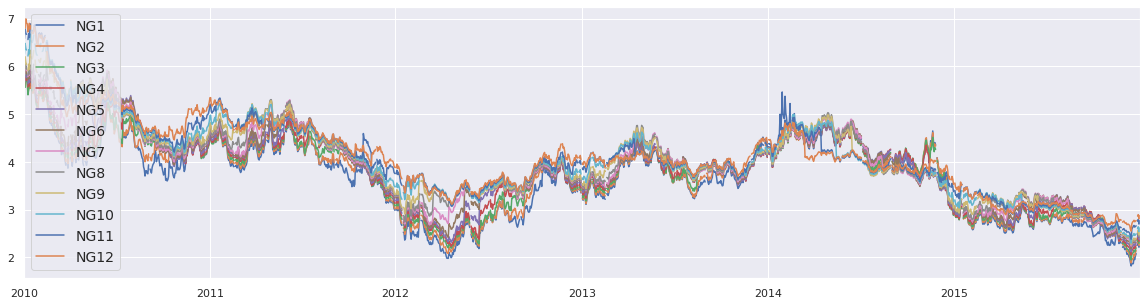

In [19]:
price_df.plot()

In [20]:
dfm = (
    cdatmode.DataFrameModeler(df=price_df, oos_start="2013-01-01")
    .compute_ret_0(method="predict")
    .apply_column_transformer(
        transformer_func=csigproc.compute_rolling_zscore,
        transformer_kwargs={
            "tau": 10,
            "min_periods": 20,
        },
        col_mode="replace_all",
        method="predict",
    )
)

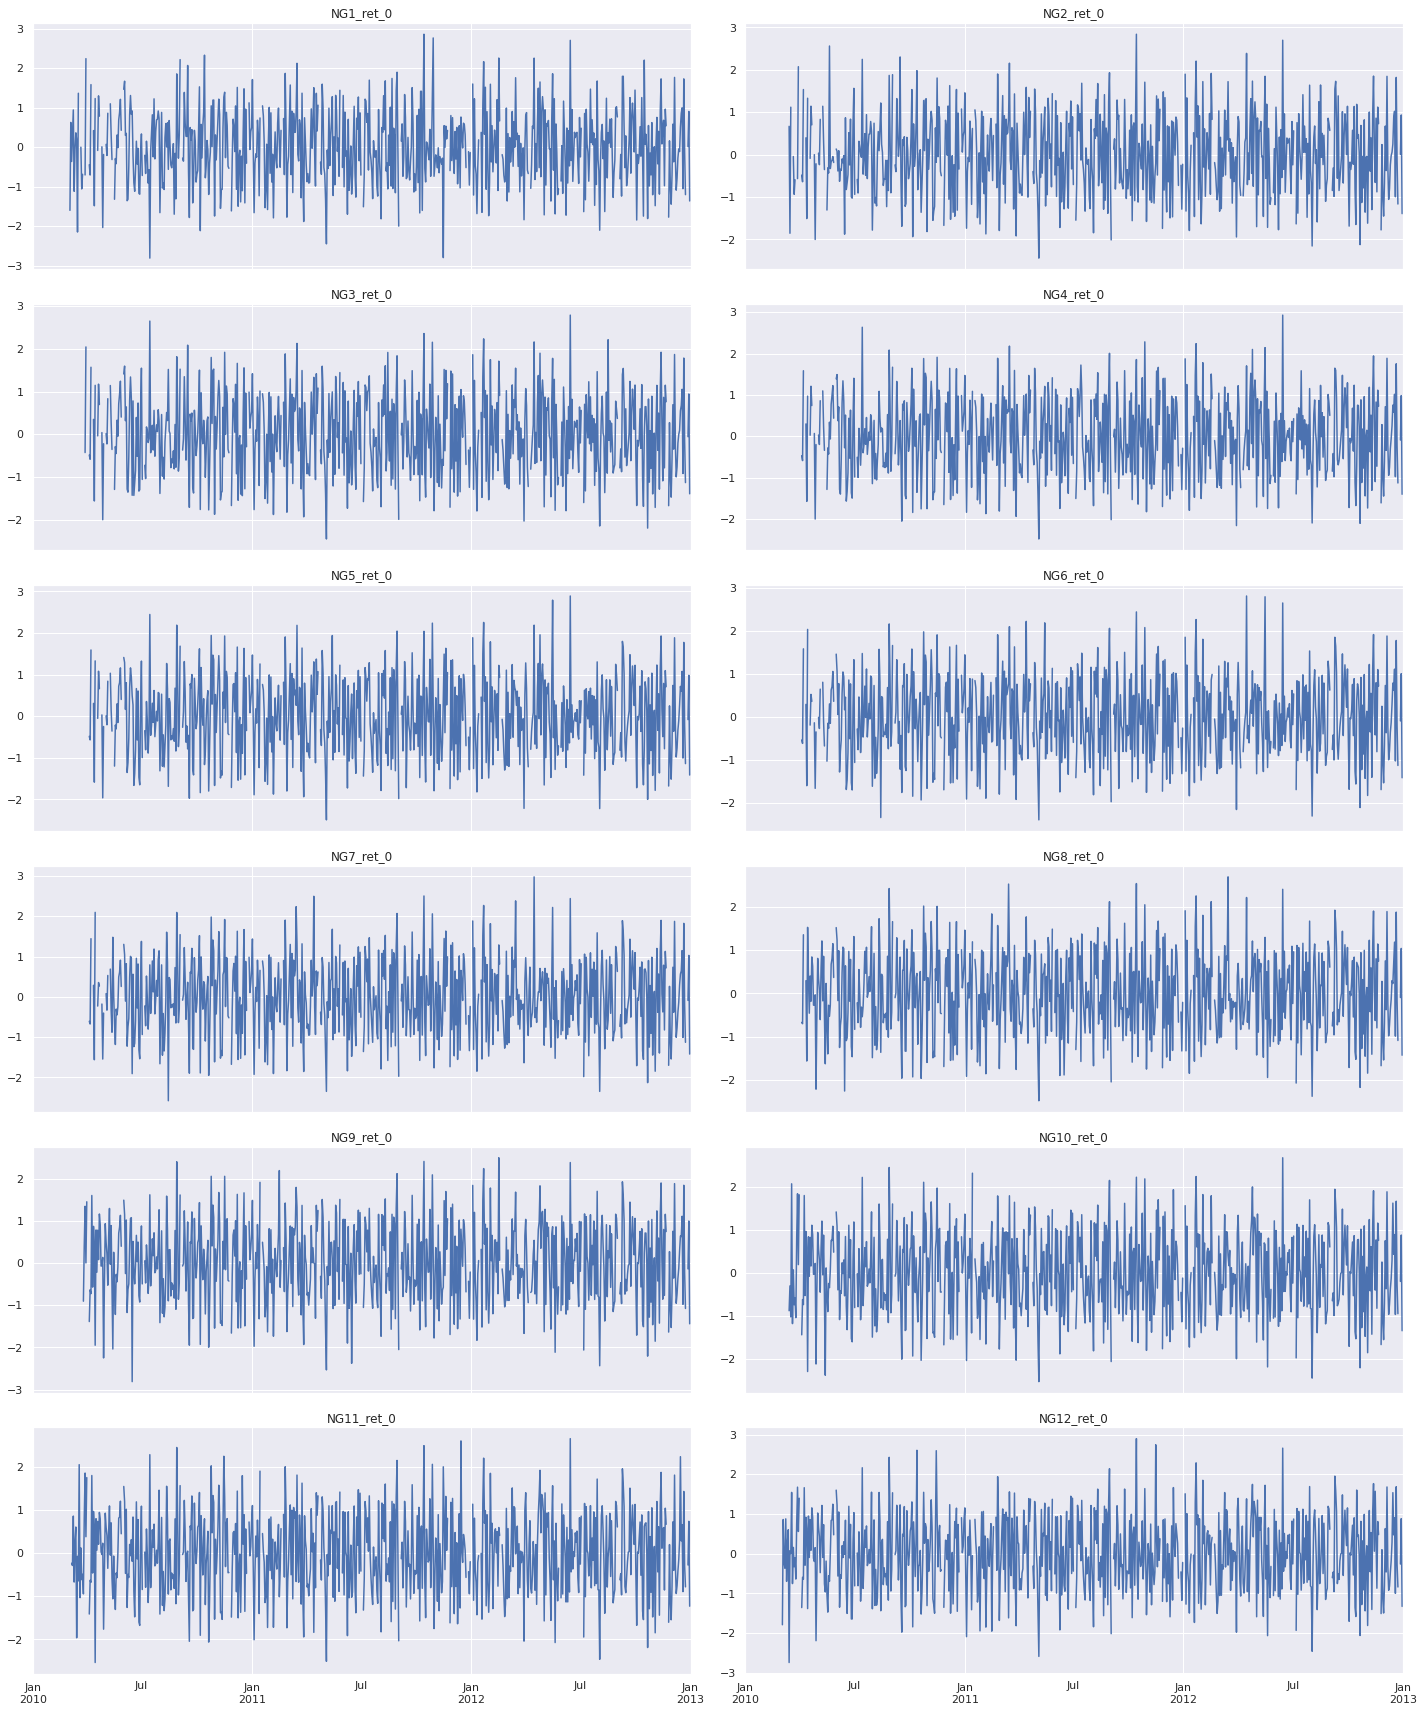

In [21]:
dfm.plot_time_series()

num_components=4


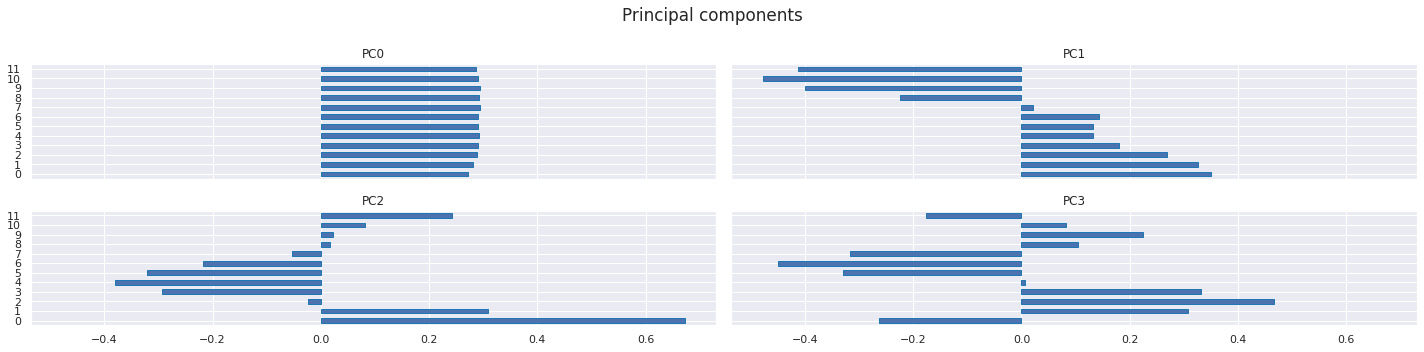

In [22]:
dfm.plot_pca_components(num_components=4)

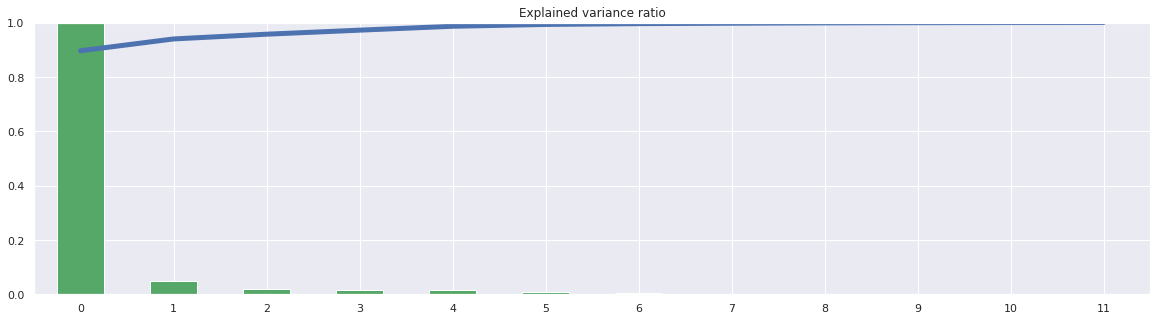

In [23]:
dfm.plot_explained_variance()

In [24]:
res = dfm.apply_residualizer(
    model_func=sklear.decomposition.PCA,
    x_vars=["NG" + str(j) + "_ret_0" for j in range(1, 13)],
    model_kwargs={"n_components": 2},
    method="predict",
).apply_column_transformer(
    transformer_func=csigproc.compute_rolling_zscore,
    transformer_kwargs={
        "tau": 10,
        "min_periods": 20,
    },
    col_mode="replace_all",
    method="predict",
)
# .apply_volatility_model(
#    cols=["NG" + str(j) + "_ret_0" for j in range(1, 13)],
#    steps_ahead=2,
# )

In [25]:
res.df

,NG1_ret_0,NG2_ret_0,NG3_ret_0,NG4_ret_0,NG5_ret_0,NG6_ret_0,NG7_ret_0,NG8_ret_0,NG9_ret_0,NG10_ret_0,NG11_ret_0,NG12_ret_0
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-29,-0.064580,-0.496960,-0.975193,-0.210249,-0.039783,0.201499,0.535365,0.811397,1.216673,0.410055,-1.120576,-0.893754
2015-12-30,-0.029479,0.081228,1.295156,0.312418,0.037497,0.053445,-0.687506,-0.783462,-1.046879,-0.920818,1.400996,0.553377


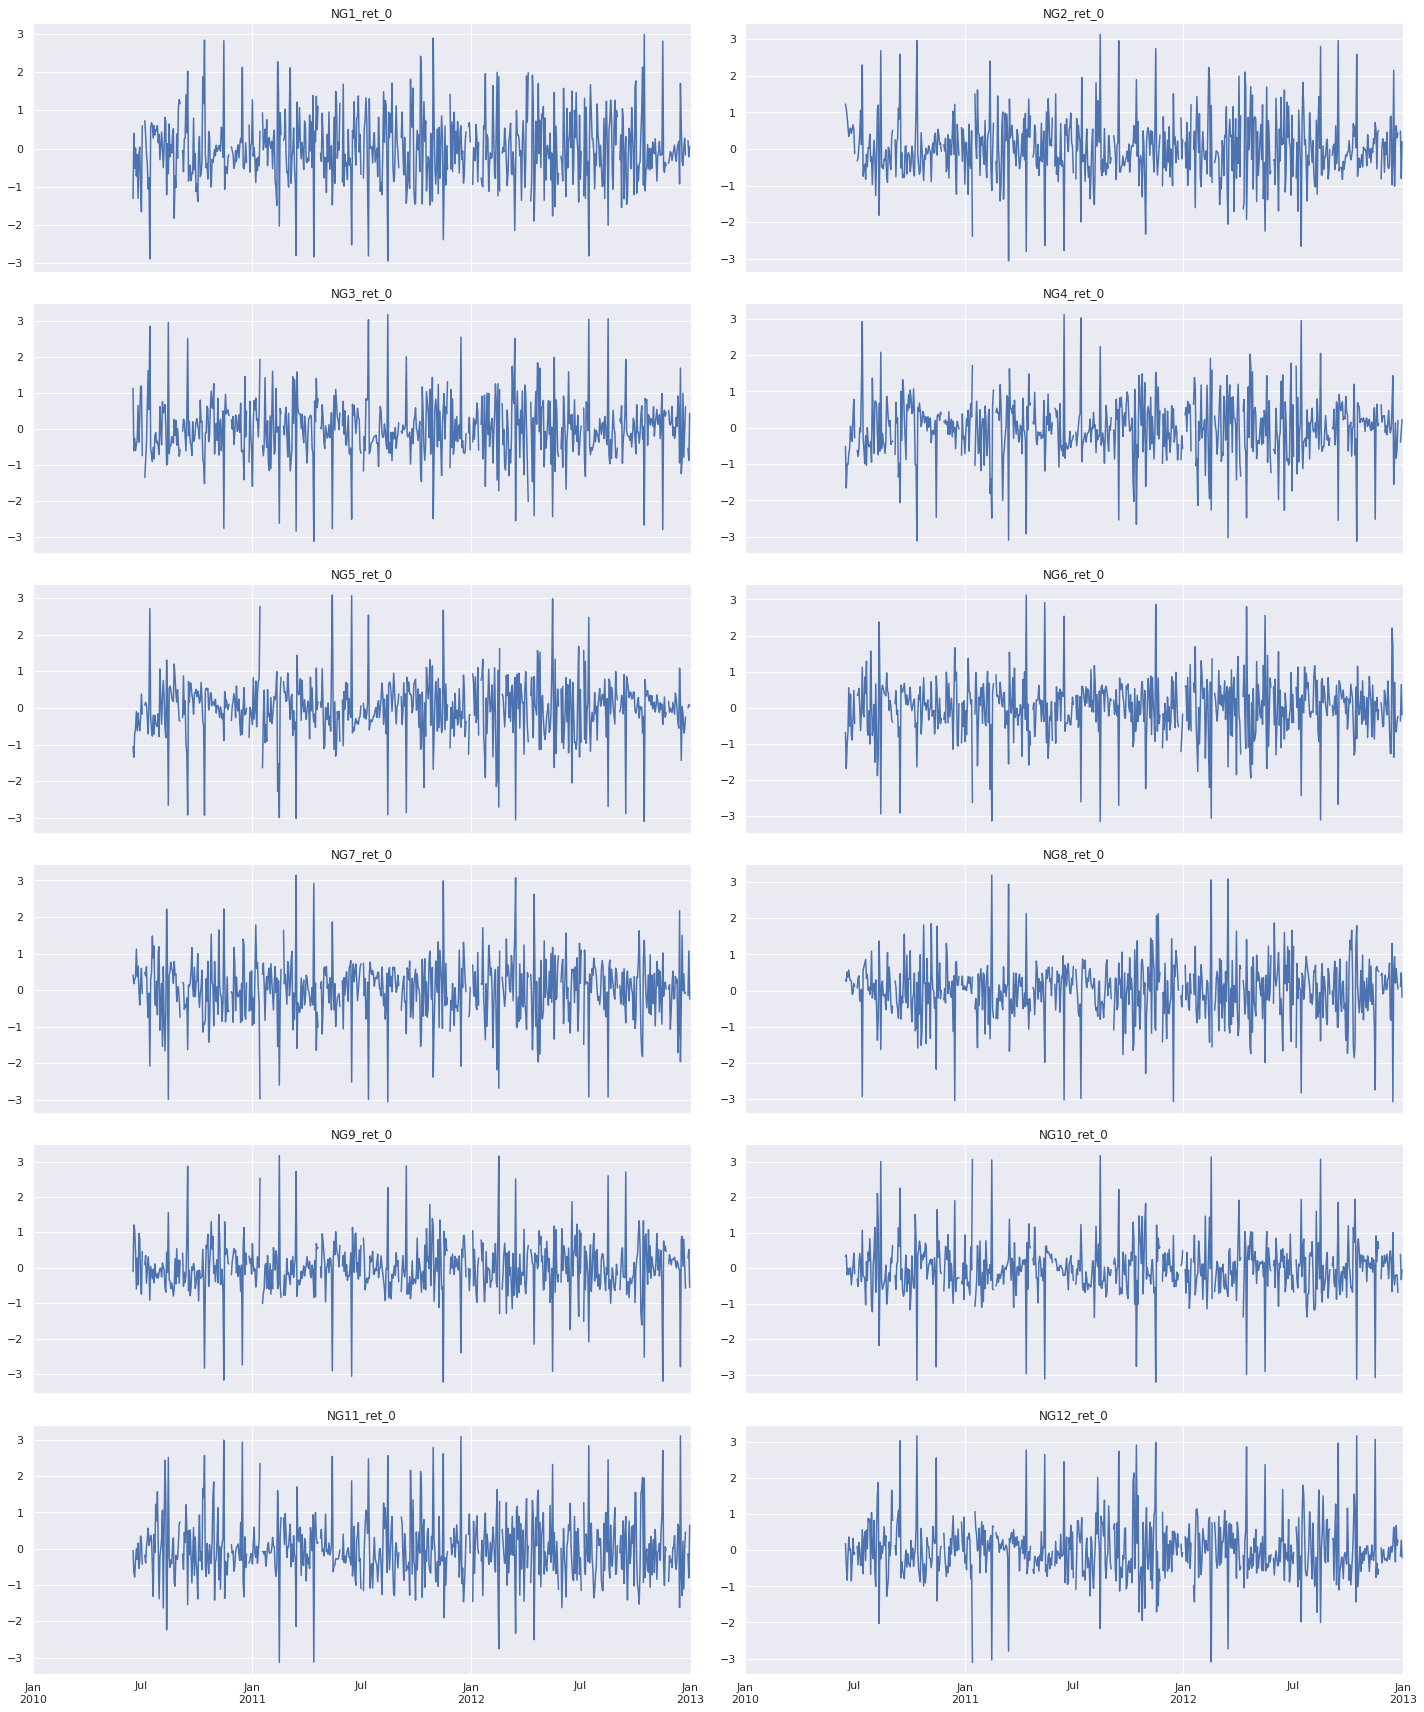

In [26]:
res.plot_time_series()

num_components=4


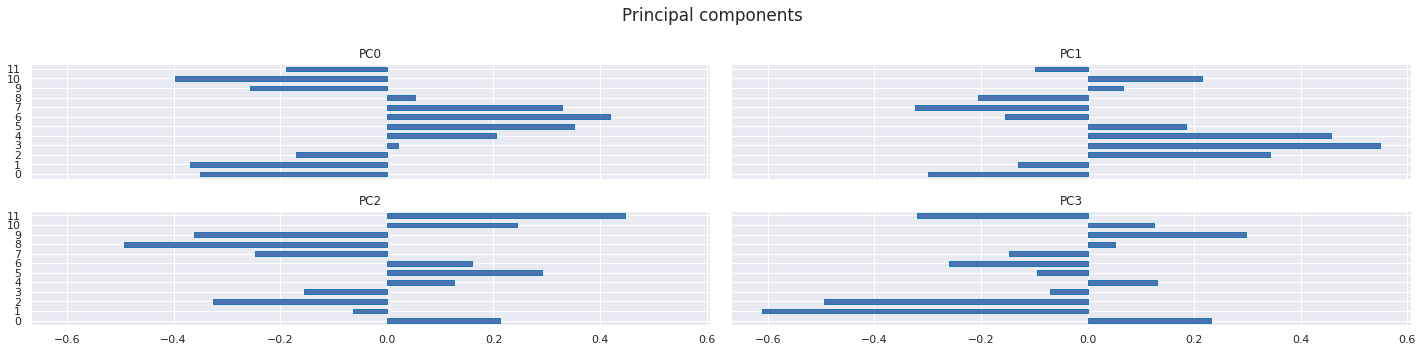

In [27]:
res.plot_pca_components(num_components=4)

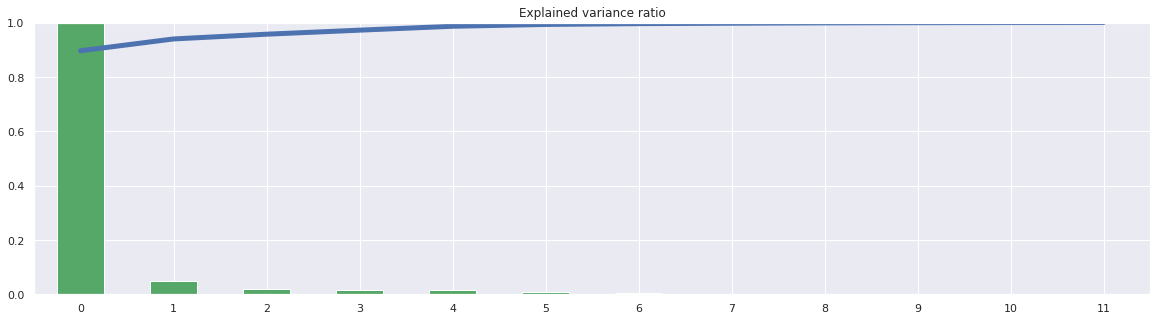

In [28]:
dfm.plot_explained_variance()

,NG1_ret_0,NG2_ret_0,NG3_ret_0,NG4_ret_0,NG5_ret_0,NG6_ret_0,NG7_ret_0,NG8_ret_0,NG9_ret_0,NG10_ret_0,NG11_ret_0,NG12_ret_0
NG1_ret_0,1.000000,0.450692,-0.231228,-0.435539,-0.449036,-0.396523,-0.341060,-0.273356,-0.124178,0.159144,0.426187,0.437739
NG2_ret_0,0.450692,1.000000,0.350442,-0.147192,-0.493008,-0.491543,-0.427322,-0.237759,0.049829,0.314823,0.370930,0.330804
NG3_ret_0,-0.231228,0.350442,1.000000,0.613932,0.115193,-0.264807,-0.407999,-0.254478,0.163588,0.417003,0.214480,-0.197798
NG4_ret_0,-0.435539,-0.147192,0.613932,1.000000,0.658499,0.183450,-0.240552,-0.302010,-0.110564,0.175672,0.138645,-0.315525
NG5_ret_0,-0.449036,-0.493008,0.115193,0.658499,1.000000,0.623229,0.167547,-0.200004,-0.343665,-0.205358,-0.011729,-0.143660
NG6_ret_0,-0.396523,-0.491543,-0.264807,0.183450,0.623229,1.000000,0.664482,0.133561,-0.392360,-0.538955,-0.249939,-0.002979
NG7_ret_0,-0.341060,-0.427322,-0.407999,-0.240552,0.167547,0.664482,1.000000,0.607117,-0.010473,-0.650625,-0.550677,-0.075110
NG8_ret_0,-0.273356,-0.237759,-0.254478,-0.302010,-0.200004,0.133561,0.607117,1.000000,0.574438,-0.216560,-0.804116,-0.406405
NG9_ret_0,-0.124178,0.049829,0.163588,-0.110564,-0.343665,-0.392360,-0.010473,0.574438,1.000000,0.445070,-0.494237,-0.534364
NG10_ret_0,0.159144,0.314823,0.417003,0.175672,-0.205358,-0.538955,-0.650625,-0.216560,0.445070,1.000000,0.270390,-0.293080


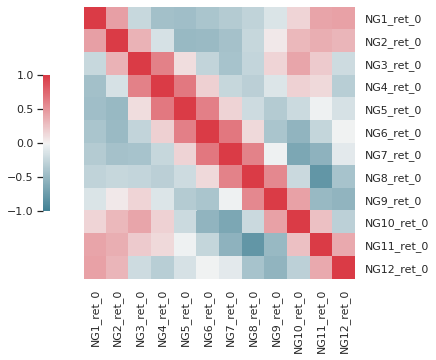

In [29]:
res.plot_correlation_matrix(mode="ins")

## Combine front and back contracts - volume

In [30]:
volume_df = ffc_obj.replace_contracts_with_data(contract_df, "vol")

In [31]:
volume_df

,NG1,NG2,NG3,NG4,NG5,NG6,NG7,NG8,NG9,NG10,NG11,NG12
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,78858.0,31238.0,16704.0,8641.0,3561.0,2241.0,2316.0,2184.0,7344.0,617.0,769.0,2113.0
2010-01-05,99492.0,36431.0,17779.0,13742.0,4157.0,2956.0,7914.0,2407.0,12158.0,1323.0,1704.0,2706.0
2010-01-06,140611.0,63141.0,37371.0,13018.0,5971.0,4426.0,2629.0,1309.0,9296.0,1007.0,2374.0,4676.0
2010-01-07,135113.0,50039.0,32131.0,12672.0,4240.0,3177.0,1361.0,1218.0,5450.0,568.0,788.0,5910.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,164756.0,55470.0,34869.0,14578.0,9555.0,8297.0,3292.0,4448.0,8090.0,1643.0,1640.0,2323.0
2015-12-29,157569.0,60752.0,42259.0,17029.0,11274.0,9580.0,5753.0,4135.0,12551.0,2024.0,2937.0,3160.0
2015-12-30,124151.0,47454.0,39020.0,13958.0,10151.0,8184.0,3989.0,2474.0,8925.0,2205.0,1464.0,2997.0


<AxesSubplot:>

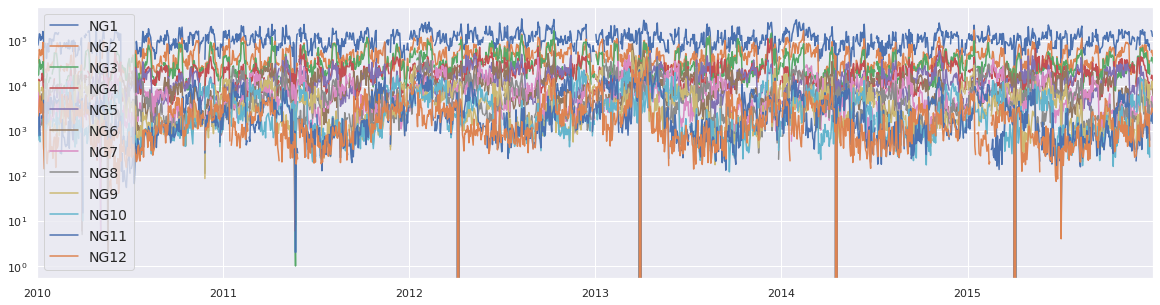

In [32]:
volume_df.plot(logy=True)